# Recommendation System Analysis

This notebook contains visualizations and metrics for the recommendation system.

**Contents:**
1. Setup & Data Loading
2. Price Distribution Analysis
3. Thompson Sampling Convergence Curves
4. MMR Effectiveness Comparison
5. Multi-Channel Retrieval (RRF) Analysis
6. Diversity Metrics
7. CTR Simulation & Offline Metrics
8. LLM Retrieval Match Quality


In [2]:
# Cell 1: Setup and Configuration
import os
import sys

# Set environment variables BEFORE importing other modules
os.environ["DB_HOST"] = "localhost"
os.environ["DB_PORT"] = "5433"
os.environ["DB_USER"] = "postgres"
os.environ["DB_PASSWORD"] = "postgres"
os.environ["DB_DB"] = "recsys"
os.environ["OLLAMA_HOST"] = "localhost"
os.environ["OLLAMA_PORT"] = "11434"
os.environ["MMR_ENABLED"] = "True"
os.environ["LLM_RETRIEVAL_ENABLED"] = "True"

# Add project root
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('')), ''))
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from typing import List, Dict, Tuple

# Set style for presentation-ready plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'success': '#28A745',
    'warning': '#FFC107',
    'danger': '#DC3545',
    'demo': '#E74C3C',
    'normal': '#3498DB'
}

print("Setup complete!")


Setup complete!


In [3]:
# Cell 2: Load Data from Database
from app.config.config import settings
from recsys import get_recommender
from recsys.recommender import RecommendationEngine, ThompsonSampler
from recsys.db_repository import get_repository

# Get singleton instances
engine = get_recommender()
repo = engine.repo

# Load products
all_products = repo.get_all_products()
main_products = repo.get_main_products()
accessory_products = repo.get_accessory_products()

print(f"Loaded {len(all_products)} total products")
print(f"  - Main products: {len(main_products)}")
print(f"  - Accessory products: {len(accessory_products)}")
print(f"\nConfiguration:")
print(f"  - DEMO_MODE: {settings.DEMO_MODE}")
print(f"  - MMR_ENABLED: {settings.MMR_ENABLED}")
print(f"  - LLM_RETRIEVAL_ENABLED: {settings.LLM_RETRIEVAL_ENABLED}")


Loaded 4654 total products
  - Main products: 186
  - Accessory products: 4468

Configuration:
  - DEMO_MODE: True
  - MMR_ENABLED: True
  - LLM_RETRIEVAL_ENABLED: True


---
## 2. Price Distribution Analysis

Analyze the price ratio between main products and recommended accessories.


In [4]:
# Cell 3: Price Distribution Analysis

def analyze_price_distribution(engine, main_products, n_samples=20):
    """
    Analyze price ratios between main products and their recommendations.
    Returns DataFrame with price ratio data.
    """
    price_ratios = []
    
    for product in main_products[:n_samples]:
        main_price = product.get('price', 0) or 0
        if main_price <= 0:
            continue
        
        # Get recommendations
        recs = engine.get_ranking(product['id'], use_vector_search=True)
        
        for rec in recs:
            acc_price = rec['recommended_product'].get('price', 0) or 0
            if acc_price > 0:
                ratio = acc_price / main_price
                price_ratios.append({
                    'main_id': product['id'],
                    'main_name': product['name'][:30],
                    'main_price': main_price,
                    'acc_id': rec['recommended_product']['id'],
                    'acc_price': acc_price,
                    'ratio': ratio,
                    'score': rec['similarity_score']
                })
    
    return pd.DataFrame(price_ratios)

# Clear cache for fresh analysis
engine._recommendation_cache.clear()

# Analyze
df_prices = analyze_price_distribution(engine, main_products, n_samples=30)
print(f"Collected {len(df_prices)} price ratio samples")
print(f"\nPrice Ratio Statistics:")
print(df_prices['ratio'].describe())


Collected 600 price ratio samples

Price Ratio Statistics:
count    600.000000
mean       0.830376
std        0.876966
min        0.009531
25%        0.263916
50%        0.625993
75%        1.120431
max        9.910180
Name: ratio, dtype: float64


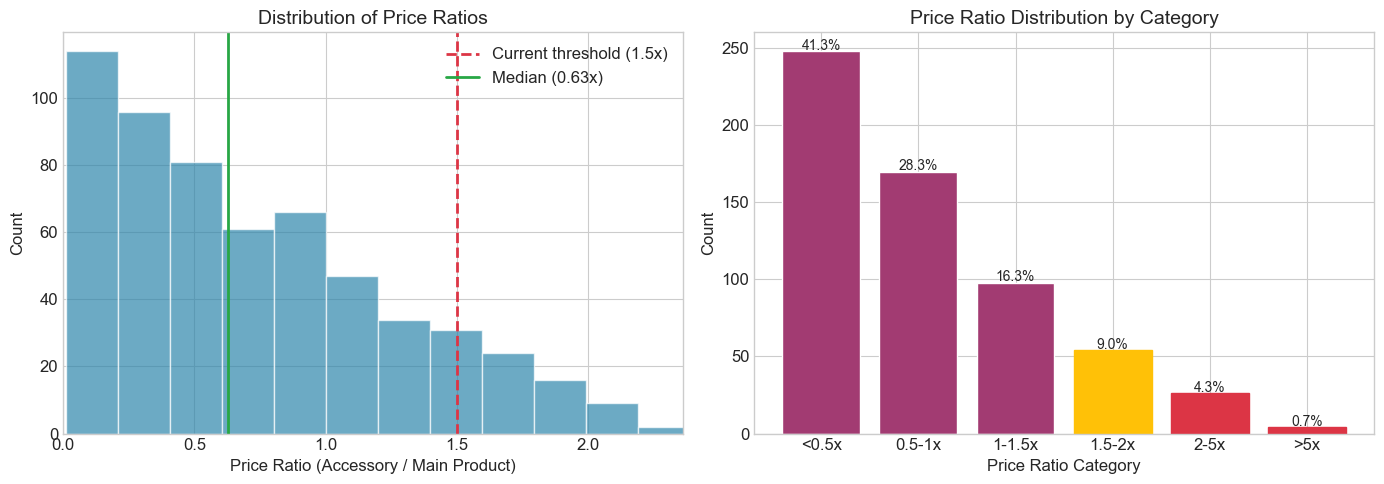


=== Price Ratio Summary ===
Items with ratio > 1.5x (current penalty zone): 84 (14.0%)
Items with ratio > 2.0x: 30 (5.0%)
Items with ratio > 5.0x: 4 (0.7%)


In [5]:
# Cell 4: Price Ratio Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram of price ratios
ax1 = axes[0]
ax1.hist(df_prices['ratio'], bins=50, color=COLORS['primary'], edgecolor='white', alpha=0.7)
ax1.axvline(x=1.5, color=COLORS['danger'], linestyle='--', linewidth=2, label='Current threshold (1.5x)')
ax1.axvline(x=df_prices['ratio'].median(), color=COLORS['success'], linestyle='-', linewidth=2, 
            label=f'Median ({df_prices["ratio"].median():.2f}x)')
ax1.set_xlabel('Price Ratio (Accessory / Main Product)')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Price Ratios')
ax1.legend()
ax1.set_xlim(0, min(df_prices['ratio'].quantile(0.95) * 1.2, 20))

# Plot 2: Box plot by ratio category
ax2 = axes[1]
df_prices['ratio_category'] = pd.cut(df_prices['ratio'], 
                                      bins=[0, 0.5, 1.0, 1.5, 2.0, 5.0, float('inf')],
                                      labels=['<0.5x', '0.5-1x', '1-1.5x', '1.5-2x', '2-5x', '>5x'])
category_counts = df_prices['ratio_category'].value_counts().sort_index()
bars = ax2.bar(category_counts.index.astype(str), category_counts.values, color=COLORS['secondary'], edgecolor='white')

# Color bars by penalty zone
for i, bar in enumerate(bars):
    if i >= 3:  # 1.5x and above
        bar.set_color(COLORS['warning'])
    if i >= 4:  # 2x and above
        bar.set_color(COLORS['danger'])

ax2.set_xlabel('Price Ratio Category')
ax2.set_ylabel('Count')
ax2.set_title('Price Ratio Distribution by Category')

# Add percentage labels
total = len(df_prices)
for bar, count in zip(bars, category_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{count/total*100:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('temp/price_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print(f"\n=== Price Ratio Summary ===")
print(f"Items with ratio > 1.5x (current penalty zone): {(df_prices['ratio'] > 1.5).sum()} ({(df_prices['ratio'] > 1.5).mean()*100:.1f}%)")
print(f"Items with ratio > 2.0x: {(df_prices['ratio'] > 2.0).sum()} ({(df_prices['ratio'] > 2.0).mean()*100:.1f}%)")
print(f"Items with ratio > 5.0x: {(df_prices['ratio'] > 5.0).sum()} ({(df_prices['ratio'] > 5.0).mean()*100:.1f}%)")


---
## 3. Thompson Sampling Convergence Curves

Simulate how E[θ] = α/(α+β) evolves with feedback in DEMO vs Normal mode.


In [6]:
# Cell 5: Thompson Sampling Simulation

def simulate_ts_convergence(init_similarity: float, 
                            true_ctr: float,
                            n_feedbacks: int = 50,
                            mode: str = 'demo'):
    """
    Simulate Thompson Sampling convergence.
    
    Args:
        init_similarity: Initial vector similarity (0-1)
        true_ctr: True click-through rate to simulate
        n_feedbacks: Number of feedback events
        mode: 'demo' or 'normal'
    
    Returns:
        List of E[θ] values over time
    """
    # Configuration based on mode
    if mode == 'demo':
        init_strength = 4.0
        update_strength = 10.0
        max_total = 100.0
    else:
        init_strength = 1.0
        update_strength = 1.0
        max_total = 100.0
    
    # Initialize alpha, beta based on similarity
    alpha = 1.0 + init_similarity * init_strength
    beta = 1.0 + (1 - init_similarity) * init_strength
    
    expected_values = [alpha / (alpha + beta)]
    
    np.random.seed(42)  # For reproducibility
    
    for _ in range(n_feedbacks):
        # Simulate feedback based on true CTR
        is_positive = np.random.random() < true_ctr
        
        # Update parameters
        if is_positive:
            alpha += update_strength
        else:
            beta += update_strength
        
        # Cap total
        total = alpha + beta
        if total > max_total:
            scale = max_total / total
            alpha *= scale
            beta *= scale
        
        expected_values.append(alpha / (alpha + beta))
    
    return expected_values

# Simulate different scenarios
scenarios = [
    {'init_sim': 0.8, 'true_ctr': 0.7, 'label': 'High relevance (sim=0.8, CTR=70%)'},
    {'init_sim': 0.5, 'true_ctr': 0.5, 'label': 'Medium relevance (sim=0.5, CTR=50%)'},
    {'init_sim': 0.3, 'true_ctr': 0.2, 'label': 'Low relevance (sim=0.3, CTR=20%)'},
]

n_feedbacks = 30

print("Simulating Thompson Sampling convergence...")


Simulating Thompson Sampling convergence...


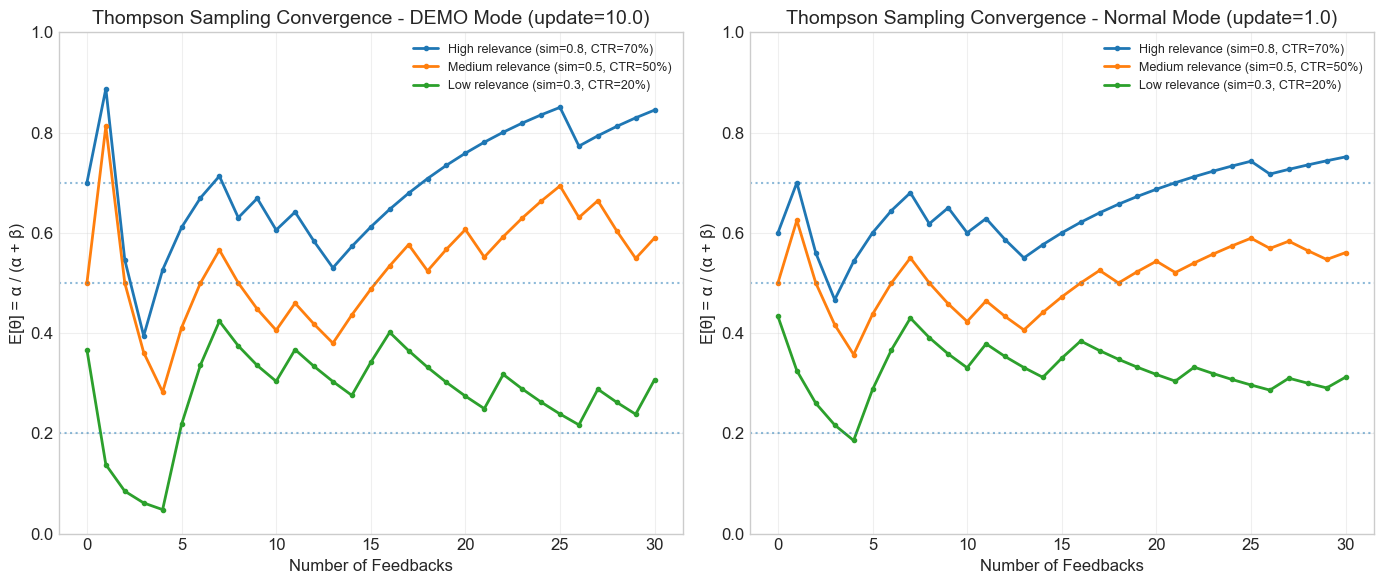


=== Key Observations ===
- DEMO mode: Fast convergence (visible change after 1-3 feedbacks)
- Normal mode: Gradual convergence (requires more data)
- Both modes converge toward true CTR over time


In [7]:
# Cell 6: TS Convergence Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for each mode
for ax, mode in zip(axes, ['demo', 'normal']):
    for scenario in scenarios:
        values = simulate_ts_convergence(
            init_similarity=scenario['init_sim'],
            true_ctr=scenario['true_ctr'],
            n_feedbacks=n_feedbacks,
            mode=mode
        )
        
        ax.plot(range(len(values)), values, 
                label=scenario['label'],
                linewidth=2, marker='o', markersize=3)
        
        # Add horizontal line for true CTR
        ax.axhline(y=scenario['true_ctr'], linestyle=':', alpha=0.5)
    
    mode_name = 'DEMO Mode' if mode == 'demo' else 'Normal Mode'
    update_str = '(update=10.0)' if mode == 'demo' else '(update=1.0)'
    ax.set_title(f'Thompson Sampling Convergence - {mode_name} {update_str}')
    ax.set_xlabel('Number of Feedbacks')
    ax.set_ylabel('E[θ] = α / (α + β)')
    ax.set_ylim(0, 1)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temp/ts_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Key Observations ===")
print("- DEMO mode: Fast convergence (visible change after 1-3 feedbacks)")
print("- Normal mode: Gradual convergence (requires more data)")
print("- Both modes converge toward true CTR over time")


---
## 4. MMR Effectiveness Comparison

Compare recommendation diversity with and without MMR.


In [8]:
# Cell 7: MMR Comparison Data Collection

def collect_mmr_comparison(engine, main_products, n_samples=10):
    """
    Collect diversity metrics with and without MMR.
    """
    results = {'with_mmr': [], 'without_mmr': []}
    
    for product in main_products[:n_samples]:
        # Clear cache
        engine._recommendation_cache.clear()
        
        for mmr_enabled, key in [(True, 'with_mmr'), (False, 'without_mmr')]:
            engine.mmr_enabled = mmr_enabled
            engine._recommendation_cache.clear()
            
            recs = engine.get_ranking(product['id'], use_vector_search=True)
            
            if len(recs) < 5:
                continue
            
            # Collect metrics
            categories = set()
            vendors = set()
            consecutive_sims = []
            
            for i, rec in enumerate(recs):
                prod = rec['recommended_product']
                categories.add(prod.get('category_name', 'Unknown'))
                vendors.add(prod.get('vendor', 'Unknown'))
                
                # Consecutive similarity (skip first 3)
                if i >= 3 and i < len(recs) - 1:
                    id1 = rec['recommended_product']['id']
                    id2 = recs[i+1]['recommended_product']['id']
                    sim = engine._get_pairwise_similarity(id1, id2)
                    if sim > 0:
                        consecutive_sims.append(sim)
            
            results[key].append({
                'product_id': product['id'],
                'unique_categories': len(categories),
                'unique_vendors': len(vendors),
                'avg_consecutive_sim': np.mean(consecutive_sims) if consecutive_sims else 0,
                'max_consecutive_sim': max(consecutive_sims) if consecutive_sims else 0,
            })
    
    # Restore MMR setting
    engine.mmr_enabled = True
    
    return {
        'with_mmr': pd.DataFrame(results['with_mmr']),
        'without_mmr': pd.DataFrame(results['without_mmr'])
    }

# Collect data
mmr_results = collect_mmr_comparison(engine, main_products, n_samples=15)
print(f"Collected MMR comparison for {len(mmr_results['with_mmr'])} products")


Collected MMR comparison for 15 products


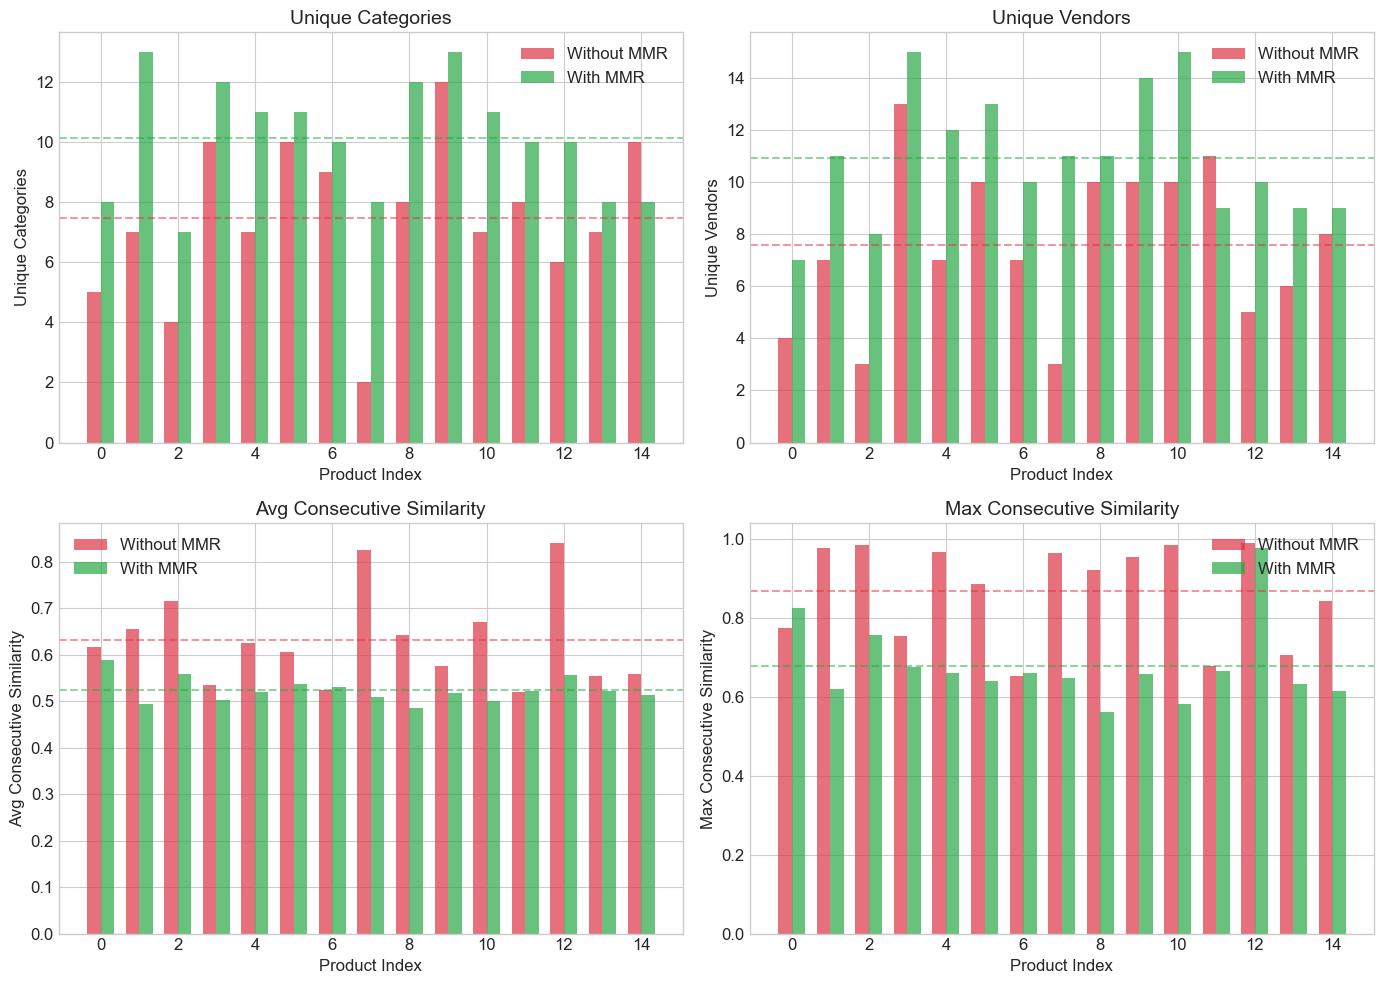


=== MMR Effectiveness Summary ===
Unique Categories: 7.467 -> 10.133 (+2.667) [better]
Unique Vendors: 7.600 -> 10.933 (+3.333) [better]
Avg Consecutive Similarity: 0.631 -> 0.524 (-0.107) [better]
Max Consecutive Similarity: 0.869 -> 0.678 (-0.191) [better]


In [9]:
# Cell 8: MMR Comparison Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ('unique_categories', 'Unique Categories', False),
    ('unique_vendors', 'Unique Vendors', False),
    ('avg_consecutive_sim', 'Avg Consecutive Similarity', True),
    ('max_consecutive_sim', 'Max Consecutive Similarity', True),
]

for ax, (metric, title, lower_is_better) in zip(axes.flat, metrics):
    without_vals = mmr_results['without_mmr'][metric]
    with_vals = mmr_results['with_mmr'][metric]
    
    x = np.arange(len(without_vals))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, without_vals, width, label='Without MMR', color=COLORS['danger'], alpha=0.7)
    bars2 = ax.bar(x + width/2, with_vals, width, label='With MMR', color=COLORS['success'], alpha=0.7)
    
    ax.set_ylabel(title)
    ax.set_xlabel('Product Index')
    ax.set_title(title)
    ax.legend()
    
    # Add mean lines
    ax.axhline(y=without_vals.mean(), color=COLORS['danger'], linestyle='--', alpha=0.5)
    ax.axhline(y=with_vals.mean(), color=COLORS['success'], linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('temp/mmr_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n=== MMR Effectiveness Summary ===")
for metric, title, lower_is_better in metrics:
    without_mean = mmr_results['without_mmr'][metric].mean()
    with_mean = mmr_results['with_mmr'][metric].mean()
    change = with_mean - without_mean
    improvement = "better" if (change < 0 and lower_is_better) or (change > 0 and not lower_is_better) else "worse"
    print(f"{title}: {without_mean:.3f} -> {with_mean:.3f} ({change:+.3f}) [{improvement}]")


---
## 5. Multi-Channel Retrieval (RRF) Analysis

Analyze the contribution of Vector and LLM channels.


In [10]:
# Cell 9: RRF Analysis

def collect_rrf_analysis(engine, main_products, n_samples=20):
    """Collect data about multi-channel retrieval effectiveness."""
    results = []
    
    for product in main_products[:n_samples]:
        # Get vector candidates
        try:
            vector_results = engine.repo.get_similar_products_by_vector(product['id'], limit=40)
        except:
            vector_results = []
        
        # Get LLM candidates
        try:
            llm_results = engine.repo.get_llm_recommendations(product['id'])
        except:
            llm_results = []
        
        # Calculate overlap
        vector_ids = {r['id'] for r in vector_results}
        llm_ids = {r['id'] for r in llm_results}
        overlap = vector_ids & llm_ids
        union = vector_ids | llm_ids
        
        results.append({
            'product_id': product['id'],
            'vector_count': len(vector_results),
            'llm_count': len(llm_results),
            'overlap_count': len(overlap),
            'union_count': len(union),
            'overlap_pct': len(overlap) / len(union) * 100 if union else 0,
            'vector_unique': len(vector_ids - llm_ids),
            'llm_unique': len(llm_ids - vector_ids),
        })
    
    return pd.DataFrame(results)

df_rrf = collect_rrf_analysis(engine, main_products, n_samples=30)
print(f"Collected RRF analysis for {len(df_rrf)} products")
print(f"\n=== RRF Summary ===")
print(f"Average Vector candidates: {df_rrf['vector_count'].mean():.1f}")
print(f"Average LLM candidates: {df_rrf['llm_count'].mean():.1f}")
print(f"Average UNION size: {df_rrf['union_count'].mean():.1f}")
print(f"Average Overlap: {df_rrf['overlap_count'].mean():.1f} ({df_rrf['overlap_pct'].mean():.1f}%)")


Collected RRF analysis for 30 products

=== RRF Summary ===
Average Vector candidates: 40.0
Average LLM candidates: 29.0
Average UNION size: 66.3
Average Overlap: 2.1 (3.3%)


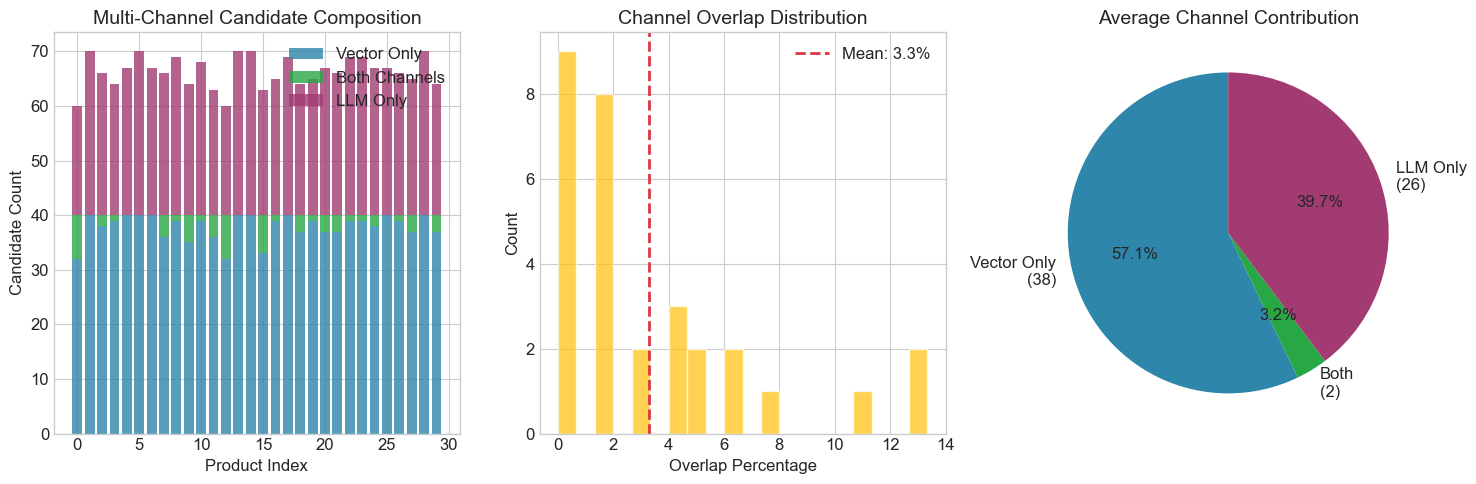

In [11]:
# Cell 10: RRF Visualization

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Stacked bar showing channel contributions
ax1 = axes[0]
x = range(len(df_rrf))
ax1.bar(x, df_rrf['vector_unique'], label='Vector Only', color=COLORS['primary'], alpha=0.8)
ax1.bar(x, df_rrf['overlap_count'], bottom=df_rrf['vector_unique'], label='Both Channels', color=COLORS['success'], alpha=0.8)
ax1.bar(x, df_rrf['llm_unique'], bottom=df_rrf['vector_unique'] + df_rrf['overlap_count'], label='LLM Only', color=COLORS['secondary'], alpha=0.8)
ax1.set_xlabel('Product Index')
ax1.set_ylabel('Candidate Count')
ax1.set_title('Multi-Channel Candidate Composition')
ax1.legend()

# Plot 2: Overlap percentage distribution
ax2 = axes[1]
ax2.hist(df_rrf['overlap_pct'], bins=20, color=COLORS['warning'], edgecolor='white', alpha=0.7)
ax2.axvline(x=df_rrf['overlap_pct'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2, 
            label=f'Mean: {df_rrf["overlap_pct"].mean():.1f}%')
ax2.set_xlabel('Overlap Percentage')
ax2.set_ylabel('Count')
ax2.set_title('Channel Overlap Distribution')
ax2.legend()

# Plot 3: Pie chart of average contributions
ax3 = axes[2]
avg_vector_unique = df_rrf['vector_unique'].mean()
avg_overlap = df_rrf['overlap_count'].mean()
avg_llm_unique = df_rrf['llm_unique'].mean()

sizes = [avg_vector_unique, avg_overlap, avg_llm_unique]
labels = [f'Vector Only\n({avg_vector_unique:.0f})', 
          f'Both\n({avg_overlap:.0f})', 
          f'LLM Only\n({avg_llm_unique:.0f})']
colors = [COLORS['primary'], COLORS['success'], COLORS['secondary']]
ax3.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax3.set_title('Average Channel Contribution')

plt.tight_layout()
plt.savefig('temp/rrf_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 6. CTR Simulation & Offline Metrics

Since we don't have user behavior logs, we can simulate offline evaluation metrics.


In [12]:
# Cell 11: CTR Tracking Structure

class CTRTracker:
    """
    Track simulated CTR metrics for recommendations.
    In production, this would be connected to actual user feedback.
    """
    
    def __init__(self):
        self.impressions = defaultdict(int)  # (main_id, rec_id) -> impression count
        self.clicks = defaultdict(int)       # (main_id, rec_id) -> click count
        self.feedback_log = []               # List of all feedback events
    
    def record_impression(self, main_product_id: int, rec_ids: List[int]):
        """Record that recommendations were shown."""
        for rec_id in rec_ids:
            self.impressions[(main_product_id, rec_id)] += 1
    
    def record_click(self, main_product_id: int, rec_id: int, is_positive: bool):
        """Record user feedback (click)."""
        if is_positive:
            self.clicks[(main_product_id, rec_id)] += 1
        self.feedback_log.append({
            'main_id': main_product_id,
            'rec_id': rec_id,
            'is_positive': is_positive,
        })
    
    def get_ctr(self, main_product_id: int = None, rec_id: int = None) -> float:
        """Calculate CTR for specific product or overall."""
        if main_product_id and rec_id:
            key = (main_product_id, rec_id)
            if self.impressions[key] == 0:
                return 0.0
            return self.clicks[key] / self.impressions[key]
        
        # Overall CTR
        total_impressions = sum(self.impressions.values())
        total_clicks = sum(self.clicks.values())
        if total_impressions == 0:
            return 0.0
        return total_clicks / total_impressions
    
    def get_summary(self) -> dict:
        """Get summary statistics."""
        return {
            'total_impressions': sum(self.impressions.values()),
            'total_clicks': sum(self.clicks.values()),
            'unique_pairs': len(self.impressions),
            'overall_ctr': self.get_ctr(),
            'feedback_events': len(self.feedback_log),
        }

# Create tracker instance
ctr_tracker = CTRTracker()
print("CTRTracker initialized.")
print("Usage:")
print("  - ctr_tracker.record_impression(main_id, [rec_ids])")
print("  - ctr_tracker.record_click(main_id, rec_id, is_positive)")
print("  - ctr_tracker.get_summary()")


CTRTracker initialized.
Usage:
  - ctr_tracker.record_impression(main_id, [rec_ids])
  - ctr_tracker.record_click(main_id, rec_id, is_positive)
  - ctr_tracker.get_summary()


In [13]:
# Cell 12: Simulate CTR Data (for demonstration)

def simulate_user_behavior(engine, main_products, ctr_tracker, n_sessions=100):
    """
    Simulate user behavior to demonstrate CTR tracking.
    Assumes higher similarity score -> higher click probability.
    """
    np.random.seed(42)
    engine._recommendation_cache.clear()
    
    for _ in range(n_sessions):
        # Random main product
        product = np.random.choice(main_products[:20])
        
        # Get recommendations
        recs = engine.get_ranking(product['id'], use_vector_search=True)
        if not recs:
            continue
        
        # Record impressions
        rec_ids = [r['recommended_product']['id'] for r in recs]
        ctr_tracker.record_impression(product['id'], rec_ids)
        
        # Simulate clicks (position bias + score-based probability)
        for i, rec in enumerate(recs[:10]):  # Users typically look at top 10
            position_factor = 1.0 / (1 + i * 0.3)  # Position decay
            score = rec['similarity_score']
            click_prob = score * position_factor * 0.3  # Base probability
            
            if np.random.random() < click_prob:
                is_positive = np.random.random() < score
                ctr_tracker.record_click(
                    product['id'], 
                    rec['recommended_product']['id'],
                    is_positive
                )
    
    return ctr_tracker.get_summary()

# Run simulation
summary = simulate_user_behavior(engine, main_products, ctr_tracker, n_sessions=200)
print("\n=== Simulated CTR Summary ===")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")



=== Simulated CTR Summary ===
  total_impressions: 4000
  total_clicks: 122
  unique_pairs: 400
  overall_ctr: 0.0305
  feedback_events: 193


---
## Summary

All analysis figures are saved to `temp/` directory for presentation use.


In [14]:
# Cell 13: Summary

print("=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

print("\nGenerated Visualizations (saved to temp/):")
print("  1. price_distribution.png - Price ratio analysis")
print("  2. ts_convergence.png - Thompson Sampling curves (DEMO vs Normal)")
print("  3. mmr_comparison.png - MMR effectiveness")
print("  4. rrf_analysis.png - Multi-channel retrieval")

print("\n=== Key Metrics ===")
if 'df_prices' in dir() and len(df_prices) > 0:
    print(f"Price ratio median: {df_prices['ratio'].median():.2f}x")
    print(f"Items > 1.5x threshold: {(df_prices['ratio'] > 1.5).mean()*100:.1f}%")

if 'mmr_results' in dir():
    cat_improvement = mmr_results['with_mmr']['unique_categories'].mean() - mmr_results['without_mmr']['unique_categories'].mean()
    sim_reduction = mmr_results['with_mmr']['max_consecutive_sim'].mean() - mmr_results['without_mmr']['max_consecutive_sim'].mean()
    print(f"MMR category improvement: +{cat_improvement:.1f}")
    print(f"MMR similarity reduction: {sim_reduction:.3f}")

if 'df_rrf' in dir() and len(df_rrf) > 0:
    print(f"Average UNION size: {df_rrf['union_count'].mean():.1f}")
    print(f"Average overlap: {df_rrf['overlap_count'].mean():.1f} ({df_rrf['overlap_pct'].mean():.1f}%)")

print("\n" + "=" * 60)
print("Analysis complete!")
print("=" * 60)


ANALYSIS SUMMARY

Generated Visualizations (saved to temp/):
  1. price_distribution.png - Price ratio analysis
  2. ts_convergence.png - Thompson Sampling curves (DEMO vs Normal)
  3. mmr_comparison.png - MMR effectiveness
  4. rrf_analysis.png - Multi-channel retrieval

=== Key Metrics ===
Price ratio median: 0.63x
Items > 1.5x threshold: 14.0%
MMR category improvement: +2.7
MMR similarity reduction: -0.191
Average UNION size: 66.3
Average overlap: 2.1 (3.3%)

Analysis complete!
